In [ ]:
!pip install yfinance

['Requirement already satisfied: yfinance in /usr/local/lib/python3.10/dist-packages (0.2.42)',
 'Requirement already satisfied: pandas>=1.3.0 in /usr/local/lib/python3.10/dist-packages (from yfinance) (2.1.4)',
 'Requirement already satisfied: numpy>=1.16.5 in /usr/local/lib/python3.10/dist-packages (from yfinance) (1.26.4)',
 'Requirement already satisfied: requests>=2.31 in /usr/local/lib/python3.10/dist-packages (from yfinance) (2.32.3)',
 'Requirement already satisfied: multitasking>=0.0.7 in /usr/local/lib/python3.10/dist-packages (from yfinance) (0.0.11)',
 'Requirement already satisfied: lxml>=4.9.1 in /usr/local/lib/python3.10/dist-packages (from yfinance) (4.9.4)',
 'Requirement already satisfied: platformdirs>=2.0.0 in /usr/local/lib/python3.10/dist-packages (from yfinance) (4.2.2)',
 'Requirement already satisfied: pytz>=2022.5 in /usr/local/lib/python3.10/dist-packages (from yfinance) (2024.1)',
 'Requirement already satisfied: frozendict>=2.3.4 in /usr/local/lib/python3.1

In [ ]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# Task 3

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go


def candlestick_chart(data, company_name):
  fig = go.Figure(data=[go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'])])
  fig.update_layout(title=f"{company_name} Candlestick Chart", xaxis_title="Date", yaxis_title="Price", xaxis_rangeslider_visible=True)
  fig.show()


def boxplot_chart(data, company_name, n_windows):
  close_prices = data['Close']

  window_data = []
  dates = []
  for i in range(0, len(close_prices) - n_windows + 1):
    window = close_prices.iloc[i:i + n_windows]
    window_data.append(window.values)
    dates.append(data.index[i + n_windows - 1].strftime('%Y-%m-%d'))

  plt.figure(figsize=(10, 6))
  plt.boxplot(window_data, labels=dates, patch_artist=True)
  plt.title(f'{company_name} Price Distribution (Sliding Window of {n_windows} Days)')
  plt.xlabel('End Date of Window')
  plt.ylabel('Closing Price')
  plt.xticks(rotation=45)
  plt.show()

def visualize_chart(company_name, chart = 'candlestick', start_date = None, end_date = None, n_windows = 3):
  data = yf.download(company_name, start = start_date, end = end_date)

  if chart == 'candlestick':
    candlestick_chart(data, company_name)
  elif chart == 'boxplot':
    boxplot_chart(data, company_name, n_windows)


In [ ]:
visualize_chart('CBA.AX', 'candlestick', '2020-01-01', '2021-01-01')

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


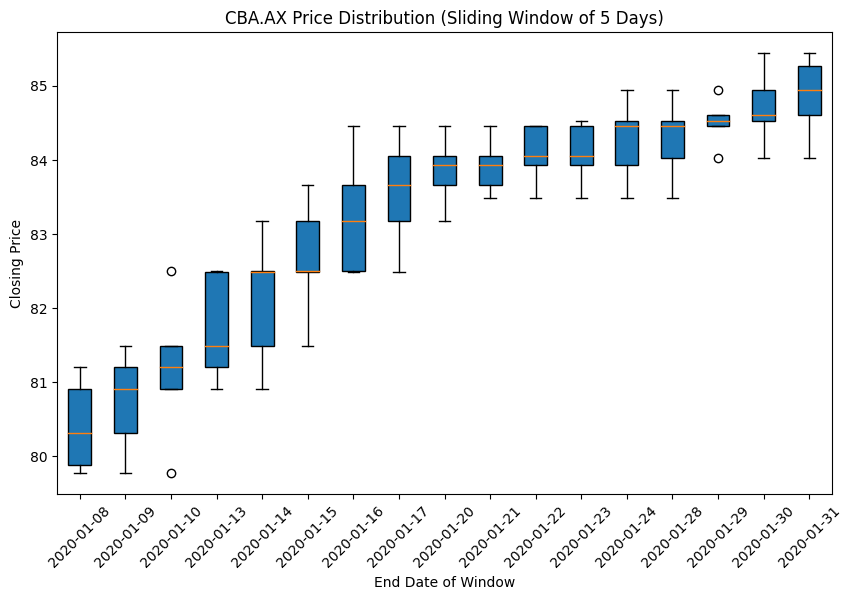

In [ ]:
visualize_chart('CBA.AX', 'boxplot', '2020-01-01', '2020-02-01', 5)

# Task 1 + Task 2

In [ ]:
import os
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def load_and_process_data(company, start_date, end_date, handle_nan='drop', split_method=None,
                          train_ratio=0.8, split_date=None, save_local=False, local_path='data.csv',
                          price_value='Close'):

    if save_local and os.path.exists(local_path):
        data = pd.read_csv(local_path, index_col=0, parse_dates=True)
    else:
        data = yf.download(company, start=start_date, end=end_date)
        if save_local:
            data.to_csv(local_path)

    if handle_nan == 'drop':
        data = data.dropna()

    scalers = {}

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[price_value].values.reshape(-1, 1))
    scalers[price_value] = scaler

    PREDICTION_DAYS = 60
    scaled_data_train = []
    scaled_data_test = []

    scaled_data = scaled_data[:, 0]
    for x in range(PREDICTION_DAYS, len(scaled_data)):
        scaled_data_train.append(scaled_data[x - PREDICTION_DAYS:x])
        scaled_data_test.append(scaled_data[x])

    scaled_data_train = np.array(scaled_data_train)
    scaled_data_test = np.array(scaled_data_test)

    scaled_data_train = np.reshape(scaled_data_train, (scaled_data_train.shape[0], scaled_data_train.shape[1], 1))

    if split_method == 'ratio':
        train_size = int(len(scaled_data_train) * train_ratio)
        x_train, x_test = scaled_data_train[:train_size], scaled_data_train[train_size:]
        y_train, y_test = scaled_data_test[:train_size], scaled_data_test[train_size:]
    elif split_method == 'date' and split_date:
        data = pd.DataFrame(data)
        split_index = data.index.get_loc(split_date)
        x_train = scaled_data_train[:split_index]
        x_test = scaled_data_train[split_index:]
        y_train = scaled_data_test[:split_index]
        y_test = scaled_data_test[split_index:]

    return x_train, y_train, x_test, y_test, scalers, scaler

x_train, y_train, x_test, y_test, scalers, scaler = load_and_process_data(
    company='CBA.AX',
    start_date='2020-01-01',
    end_date='2023-08-01',
    handle_nan='drop',
    save_local=True,
    local_path='cba_data.csv',
    price_value='Close',
    split_method='ratio',
    train_ratio=0.8
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(scalers['Close'].inverse_transform(y_train.reshape(-1, 1))[0])


[*********************100%***********************]  1 of 1 completed

(676, 60, 1)
(676,)
(169, 60, 1)
(169,)
[57.65999985]


# Task 4

In [ ]:
import numpy as np

from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, GRU, SimpleRNN
from tensorflow.keras.models import Sequential

def lstm_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,1], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model.add(LSTM(units=units[0], return_sequences=True, activation=activations[0],input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(dropout))

  for i in range(n_layers - 3):
    model.add(LSTM(units=units[i+1], return_sequences=True, activation=activations[i+1]))
    model.add(Dropout(dropout))

  model.add(LSTM(units=units[-2], activation=activations[-2]))
  model.add(Dropout(dropout))

  model.add(Dense(units=units[-1], activation=activations[-1]))

  model.compile(optimizer=optimizer, loss=loss)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)

  return model

def gru_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,50], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model.add(GRU(units=units[0], return_sequences=True, activation=activations[0], input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(dropout))


  for i in range(n_layers - 3):
    model.add(GRU(units=units[i+1], return_sequences=True, activation=activations[i+1]))
    model.add(Dropout(dropout))

  model.add(GRU(units=units[-2], activation=activations[-2]))
  model.add(Dropout(dropout))
  model.add(Dense(units=units[-1], activation=activations[-1]))

  model.compile(optimizer=optimizer, loss=loss)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)
  return model

def rnn_model(x_train, y_train, model, epoch, batchSize, n_layers=4, dropout=0.2, units=[50,50,50,50], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
    model.add(SimpleRNN(units=units[0], return_sequences=True, activation=activations[0], input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(dropout))

    for i in range(n_layers - 3):
        model.add(SimpleRNN(units=units[i+1], return_sequences=True, activation=activations[i+1]))
        model.add(Dropout(dropout))

    model.add(SimpleRNN(units=units[-1], activation=activations[-2]))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation=activations[-1]))

    model.compile(optimizer=optimizer, loss=loss)
    model.fit(x_train, y_train, epochs=epoch, batch_size=batchSize)

    return model


def model_load(x_train, y_train, modelName='LSTM', epoch=25, batchSize=32, layers=4, dropout=0.2, units=[50,50,50,1], activations=['tanh', 'tanh', 'tanh', 'linear'], optimizer='adam', loss='mean_squared_error'):
  model = Sequential()
  if layers != len(units) != len(activations):
    print('Number of layers and units and activation function do not match')
    return None

  if modelName == 'LSTM':
    return lstm_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  elif modelName == 'GRU':
    return gru_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  elif modelName == 'RNN':
    return rnn_model(x_train, y_train, model, epoch, batchSize, layers, dropout, units, activations, optimizer, loss)
  else:
    print('Invalid model name')
    return None


In [ ]:
model = model_load(x_train, y_train, 'GRU', 30, 24, 4, 0.2, [30,20,10,1], ['tanh', 'tanh', 'tanh','linear'], 'adam', 'mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.1687
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0291
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0212
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0207
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0172
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0196
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0214
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0172
Epoch 9/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0171
Epoch 10/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0139
Epoch 11/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0149
Epoch 12/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0133
Epoch 13/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0133
Epoch 14/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0148
Epoch 15/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0142
Epo

In [ ]:
model = model_load(x_train, y_train, 'RNN', 30, 24, 5, 0.25, [40,30,20,10,1], ['relu', 'relu', 'relu', 'relu', 'linear'],'adam', 'mean_squared_error')

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.2938
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.2493
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2226
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1997
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1930
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1562
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1429
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1433
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1238
Epoch 10/30
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1076

KeyboardInterrupt: 

In [ ]:
model = model_load(x_train, y_train, 'RNN', 35, 32, 10, 0.25, [160,140,120,100,80,60,40,20,10,1], ['relu','relu', 'relu', 'relu', 'relu','relu','relu', 'relu', 'relu', 'linear'], 'adam', 'mean_squared_error')

Epoch 1/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 209ms/step - loss: 62.7370
Epoch 2/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - loss: 0.4115
Epoch 3/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.4063
Epoch 4/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.3905
Epoch 5/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.3928
Epoch 6/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.3709
Epoch 7/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - loss: 0.3734
Epoch 8/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.3478
Epoch 9/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - loss: 0.3532
Epoch 10/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.3525
Epoch 11/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.3236
Epoch 12/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.3211
Epoch 13/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - loss: 0.2927
Epoch 14/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 0.3088
Epoch 15/35
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - 

# Task 6

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, RNN
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
def build_gru_model(input_shape):
    model = Sequential()
    model.add(layers.GRU(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.GRU(40, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

gru_model = build_gru_model((x_train.shape[1], 1))
gru_model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_test, y_test), verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.2168 - val_loss: 0.0192
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0199 - val_loss: 9.8407e-04
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0152 - val_loss: 0.0011
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0130 - val_loss: 0.0016
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0104 - val_loss: 0.0026
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0109 - val_loss: 0.0065
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0109 - val_loss: 0.0017
Epoch 9/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0083 - val_loss: 0.0015
Epoch 10/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0082 - val_loss: 0.0010
Epoch 11/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0099 - val_loss: 0.0010
Epoch 12/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss:

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(layers.LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(40, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model((x_train.shape[1], 1))
lstm_model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_test, y_test), verbose=1)

Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.2106 - val_loss: 0.0040
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0199 - val_loss: 0.0033
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0137 - val_loss: 0.0052
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0139 - val_loss: 0.0063
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0130 - val_loss: 0.0066
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0137 - val_loss: 0.0026
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0109 - val_loss: 0.0032
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0096 - val_loss: 0.0025
Epoch 9/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0090 - val_loss: 0.0022
Epoch 10/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0094 - val_loss: 0.0020
Epoch 11/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 12/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0

In [ ]:
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(layers.SimpleRNN(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.SimpleRNN(40, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

rnn_model = build_rnn_model((x_train.shape[1], 1))
rnn_model.fit(x_train, y_train, epochs=25, batch_size=16, validation_data=(x_test, y_test), verbose=1)

Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.2993 - val_loss: 0.0118
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0293 - val_loss: 0.0065
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0250 - val_loss: 8.5540e-04
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0222 - val_loss: 0.0013
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0163 - val_loss: 0.0024
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0152 - val_loss: 0.0025
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0143 - val_loss: 0.0015
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0129 - val_loss: 0.0022
Epoch 9/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0123 - val_loss: 0.0030
Epoch 10/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0115 - val_loss: 6.3966e-04
Epoch 11/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0121 - val_loss: 9.9906e-04
Epoch 12/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

In [ ]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(y_train.flatten(), start_p=1, start_q=1,
                         max_p=5, max_q=5, seasonal=False, trace=True, stepwise=True)
arima_model_fit = arima_model

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3182.229, Time=4.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3186.006, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3184.224, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3184.233, Time=2.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3185.774, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 7.924 seconds


In [ ]:
sarima_model = auto_arima(y_train.flatten(), start_p=1, start_q=1,
                          max_p=5, max_q=5, seasonal=True, m=12,
                          start_P=0, start_Q=0, max_P=2, max_Q=2, d=None, D=1,
                          trace=True, stepwise=True, suppress_warnings=True, error_action='ignore')

sarima_model_fit = sarima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-2670.986, Time=3.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1446.780, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2881.884, Time=3.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-2087.225, Time=3.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1428.989, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-2669.465, Time=0.50 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-2958.389, Time=13.01 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=15.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-1457.219, Time=4.39 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-2957.496, Time=15.03 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-2957.482, Time=15.44 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-2083.785, Time=13.12 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-2946.612, Time=16.43 sec
 ARIMA(1,0,

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

def stacked_model(x_train, x_test, y_train, y_test, base_models):

    # Initialize lists to store predictions for training and testing
    meta_features_train = []
    meta_features_test = []

    # Generate predictions for each base model
    for model in base_models:
        # Check if the model is an ARIMA model
        if 'pmdarima.arima' in str(type(model)):
            # For ARIMA, predict based on the number of periods in test data
            train_pred = model.predict(n_periods=len(x_train)).flatten()
            test_pred = model.predict(n_periods=len(x_test)).flatten()
        else:
            train_pred = model.predict(x_train).flatten()
            test_pred = model.predict(x_test).flatten()

        meta_features_train.append(train_pred)
        meta_features_test.append(test_pred)

    # Stack all base model predictions as meta features
    meta_features_train = np.column_stack(meta_features_train)
    meta_features_test = np.column_stack(meta_features_test)

    # Train the meta-model
    rf_meta_model = RandomForestRegressor()
    rf_meta_model.fit(meta_features_train, y_train)

    # Final predictions from the meta-model
    final_predictions = rf_meta_model.predict(meta_features_test)

    # Evaluate the meta-model
    mse = mean_squared_error(y_test, final_predictions)
    r2 = r2_score(y_test, final_predictions)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R² Score: {r2}')

    return final_predictions, mse, r2

In [ ]:
base_models = [arima_model, lstm_model]
final_predictions, mse, r2 = stacked_model(x_train, x_test, y_train, y_test, base_models)
print(mse)
print(r2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error (MSE): 0.14653131521683732
R² Score: -23.636206756441712
0.14653131521683732
-23.636206756441712


In [ ]:
base_models = [sarima_model, lstm_model]
final_predictions, mse, r2 = stacked_model(x_train, x_test, y_train, y_test, base_models)
print(mse)
print(r2)

In [ ]:
base_models = [arima_model, lstm_model, rnn_model, gru_model]
final_predictions, mse, r2 = stacked_model(x_train, x_test, y_train, y_test, base_models)
print(mse)
print(r2)

In [ ]:
base_models = [sarima_model, lstm_model, rnn_model, gru_model]
final_predictions, mse, r2 = stacked_model(x_train, x_test, y_train, y_test, base_models)
print(mse)
print(r2)

In [ ]:
base_models = [lstm_model, rnn_model, gru_model]
final_predictions, mse, r2 = stacked_model(x_train, x_test, y_train, y_test, base_models)
print(mse)
print(r2)

In [ ]:
lstm_predictions_test = lstm_model.predict(x_test)
gru_predictions_test = gru_model.predict(x_test)
rnn_predictions_test = rnn_model.predict(x_test)
arima_predictions_test = arima_model.predict(x_test)
sarima_predictions_test = sarima_model.predict(x_test)

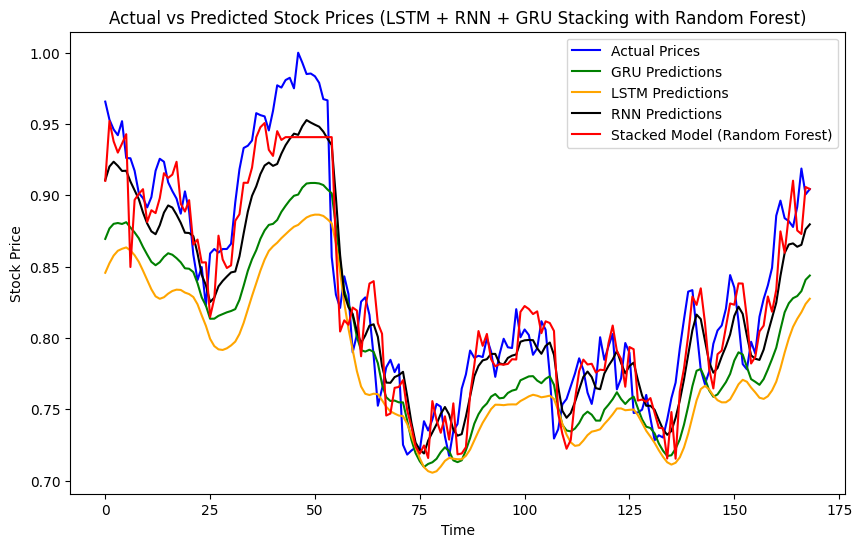

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(gru_predictions_test, label='GRU Predictions', color='green')
plt.plot(lstm_predictions_test, label='LSTM Predictions', color='orange')
plt.plot(rnn_predictions_test, label='RNN Predictions', color='black')
plt.plot(arima_predictions_test, label='ARIMA Predictions', color='purple')
plt.plot(sarima_predictions_test, label='SARIMA Predictions', color='violet')
plt.plot(final_predictions, label='Stacked Model (Random Forest)', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM + RNN + GRU Stacking with Random Forest)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

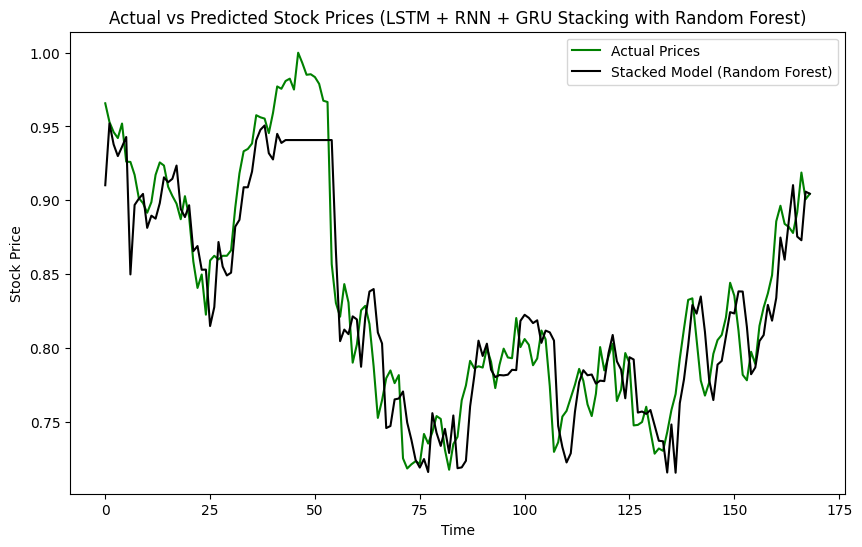

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='green')
plt.plot(final_predictions, label='Stacked Model (Random Forest)', color='black')
plt.title('Actual vs Predicted Stock Prices (LSTM + RNN + GRU Stacking with Random Forest)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Task 5

In [ ]:
import os
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def multivariate_data(company, start_date, end_date, handle_nan='drop', split_method=None,
                      train_ratio=0.8, split_date=None, save_local=False, local_path='data.csv'):
    if save_local and os.path.exists(local_path):
        data = pd.read_csv(local_path, index_col=0, parse_dates=True)
    else:
        data = yf.download(company, start=start_date, end=end_date)
        if save_local:
            data.to_csv(local_path)

    if handle_nan == 'drop':
        data = data.dropna()

    features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    scalers = {}
    scaled_features = []

    for feature in features:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_feature = scaler.fit_transform(data[feature].values.reshape(-1, 1))
        scaled_features.append(scaled_feature)
        scalers[feature] = scaler

    scaled_data = np.concatenate(scaled_features, axis=1)

    PREDICTION_DAYS = 60
    x_data = []
    y_data = []

    for x in range(PREDICTION_DAYS, len(scaled_data) - 5 + 1):
        x_data.append(scaled_data[x - PREDICTION_DAYS:x])
        y_data.append(scaled_data[x:x + 5, features.index('Close')])

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    if split_method == 'ratio':
        train_size = int(len(x_data) * train_ratio)
        x_train, x_test = x_data[:train_size], x_data[train_size:]
        y_train, y_test = y_data[:train_size], y_data[train_size:]
    elif split_method == 'date' and split_date:
        split_index = data.index.get_loc(pd.to_datetime(split_date)) - PREDICTION_DAYS
        x_train = x_data[:split_index]
        x_test = x_data[split_index:]
        y_train = y_data[:split_index]
        y_test = y_data[split_index:]

    return x_train, y_train, x_test, y_test, scalers, scaler, features

x_train, y_train, x_test, y_test, scalers, scaler, features = multivariate_data(
    company='CBA.AX',
    start_date='2020-01-01',
    end_date='2023-08-01',
    handle_nan='drop',
    save_local=True,
    local_path='cba_data.csv',
    split_method='date',
    split_date='2023-03-01'
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(740, 60, 6)
(740, 5)
(101, 60, 6)
(101, 5)


In [ ]:
pd.DataFrame(x_train[0, :].reshape(-1, 6))

,0,1,2,3,4,5
0,0.430875,0.418050,0.455663,0.450343,0.354186,0.063919
1,0.452256,0.436137,0.470764,0.457901,0.360431,0.076308
2,0.429788,0.411710,0.452853,0.448409,0.352589,0.106688
3,0.449538,0.436323,0.469535,0.473545,0.373354,0.123976
4,0.456786,0.437255,0.466901,0.468272,0.368998,0.082087
5,0.461859,0.448257,0.486918,0.478643,0.377566,0.159776
6,0.464215,0.460563,0.494557,0.496397,0.392232,0.151441
7,0.472731,0.462055,0.496752,0.496045,0.391942,0.065023
8,0.488313,0.479582,0.515013,0.508174,0.401962,0.141154
9,0.490850,0.484244,0.520808,0.516787,0.409078,0.101294


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def build_lstm_multistep_model(n_steps_in, n_features, n_steps_out):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(40, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(30, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model

def predict_multistep_multivariate_closing_prices(X_train, y_train, X_test, y_test, scalers, n_steps_in, n_steps_out, epochs=35):
    n_features = X_train.shape[2]
    model = build_lstm_multistep_model(n_steps_in, n_features, n_steps_out)

    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {loss}')

    last_sequence = X_test[-1]
    last_sequence = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

    predicted_closing_prices = model.predict(last_sequence, verbose=0)

    predicted_closing_prices = scalers['Close'].inverse_transform(predicted_closing_prices)

    return predicted_closing_prices[0]

def recursive_multistep_forecasting(X_train, y_train, X_test, y_test, scalers, features, n_steps_in, n_steps_out, epochs=35):
    n_features = X_train.shape[2]
    model = build_lstm_multistep_model(n_steps_in, n_features, 1)

    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {loss}')

    predictions = []

    last_sequence = X_test[-1]
    for step in range(n_steps_out):
        last_sequence_reshaped = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

        predicted_price = model.predict(last_sequence_reshaped, verbose=0)

        predictions.append(predicted_price[0][0])

        new_row = np.copy(last_sequence[-1, :])

        new_row[features.index('Close')] = last_sequence[-1, features.index('Close')]

        last_sequence = np.vstack([last_sequence[1:], new_row])

    predictions = np.array(predictions).reshape(-1, 1)
    predicted_closing_prices = scalers['Close'].inverse_transform(predictions)

    return predicted_closing_prices


In [ ]:
future_predictions = predict_multistep_multivariate_closing_prices(x_train, y_train, x_test, y_test, scalers, 60, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test loss: 0.0016215068753808737


In [ ]:
future_predictions = recursive_multistep_forecasting(x_train, y_train, x_test, y_test, scalers, features, 60, 5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Test loss: 0.003679933026432991


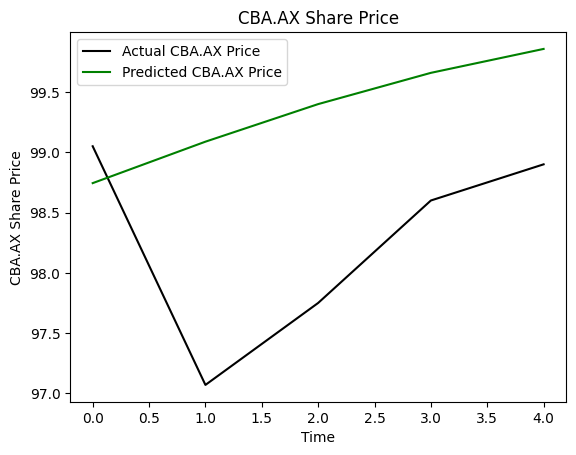

In [ ]:
from matplotlib import pyplot as plt

COMPANY = 'CBA.AX'
predicted_prices = np.array(future_predictions)

# y_test = scalers['Close'].inverse_transform(y_test[:5].reshape(-1, 1))
# predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))

plt.plot(y_test[:5], color="black", label=f"Actual {COMPANY} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {COMPANY} Price")
plt.title(f"{COMPANY} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{COMPANY} Share Price")
plt.legend()
plt.show()